In [134]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats

import xgboost as xgb

import pickle

## Załadowanie danych

In [ ]:
rename_cols = False

In [153]:
dirpath = 'z3' # ścieżka do katalogu wyłącznie z plikami z rozszerzeniem .gz
df = pd.concat([pd.read_csv(os.path.join(dirpath, fname))
                for fname in os.listdir(dirpath)], ignore_index=True)

df['czas'] = df['czas'].str[:19]
df['czas'] = pd.to_datetime(df['czas'], format='%Y-%m-%d %H:%M:%S')

col_df = pd.read_excel('opis_zmiennych.xlsx')# ścieżka do excela z opisem zmiennych
col_df['opis'] = col_df['opis'] + ' ' + col_df['Jednostka']
col_df.drop(columns=['Jednostka'], inplace=True)

names_dict = col_df.set_index('Tagname').to_dict()['opis']
names_dict =  {k.lower(): v for k, v in names_dict.items()}

if rename_cols:
    df.rename(columns=names_dict, inplace=True)

temp = pd.read_csv('temp_zuz.csv', delimiter=';') # ścieżka do pliku csv z historycznymi temperaturami
temp.rename(columns={'Czas': 'czas'}, inplace=True)
temp['czas'] = pd.to_datetime(temp['czas'])

merged = pd.merge(df, temp, how='left', on='czas')

## Ustawienie indeksu na timestampy

In [154]:
df = merged.copy()
df.set_index(['czas'], inplace=True)
df = df[~df.index.duplicated()]
df = df.asfreq('T')
df.index

DatetimeIndex(['2020-10-01 00:00:00', '2020-10-01 00:01:00',
               '2020-10-01 00:02:00', '2020-10-01 00:03:00',
               '2020-10-01 00:04:00', '2020-10-01 00:05:00',
               '2020-10-01 00:06:00', '2020-10-01 00:07:00',
               '2020-10-01 00:08:00', '2020-10-01 00:09:00',
               ...
               '2022-01-31 23:50:00', '2022-01-31 23:51:00',
               '2022-01-31 23:52:00', '2022-01-31 23:53:00',
               '2022-01-31 23:54:00', '2022-01-31 23:55:00',
               '2022-01-31 23:56:00', '2022-01-31 23:57:00',
               '2022-01-31 23:58:00', '2022-01-31 23:59:00'],
              dtype='datetime64[ns]', name='czas', length=702720, freq='T')

## Wybór najbardziej skorelowanych kolumn

In [159]:
threshold = 0.2

correlated_cols = df.columns[df.corr()['temp_zuz'].abs() > threshold].tolist()
correlated_cols.remove('temp_zuz')
print(correlated_cols)

['001fir01308.daca.pv', '001fir01309.daca.pv', '001fir01310.daca.pv', '001fir01311.daca.pv', '001fir01312.daca.pv', '001fir01315.daca.pv', '001nir0szr0.daca.pv', '001tix01063.daca.pv', '001tix01065.daca.pv', '001tix01067.daca.pv', '001tix01068.daca.pv', '001tix01071.daca.pv', '001tix01075.daca.pv', '001tix01079.daca.pv', '001uxm0rf01.daca.pv', '001uxm0rf02.daca.pv', '001uxm0rf03.daca.pv']


## Dodawanie temperatur z ostatnich pomiarów, do aktualnie estymowanej obserwacji

In [160]:
def last_h(df, n_hours):
    temp = df['temp_zuz'].copy()
    for n in range(1, n_hours+1):
        label = 'temp_last' + '_' + str(n)
        df[label] = temp.fillna(method='ffill').shift(periods=1+60*(n-1))

In [161]:
last_h(df, 4)

cols = list(df.columns)
cols.remove('temp_zuz')

df = df.dropna(subset=cols)

## Dodawanie uśrednionych wartości najbardziej znaczących parametrów w poszczególnych kwadransach godziny poprzedzającej obserwację

In [162]:
col_names = correlated_cols

new_df = df.copy()

new_df = pd.concat([new_df, new_df[col_names].rename(columns=lambda col_name: f'{col_name}_avg_00-15').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=15, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_15-30').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=30, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_30-45').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=45, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_45-60').rolling(window=15).mean()], axis=1)
    

## Wybór najbardziej znaczących zmiennych

In [164]:
threshold = 0.165

correlated_cols = new_df.columns[new_df.corr()['temp_zuz'].abs() > threshold].tolist()
corr_df = new_df[correlated_cols].copy()

## Interpolacja brakujących rekordów

In [165]:
corr_df['temp_zuz'] = corr_df['temp_zuz'].interpolate()
df = corr_df.dropna()

## Odrzucenie wartości znacznie odbiegających od normy

In [166]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

## Dodanie informacji o czasie ubiegłym od ostatniego pomiaru temperatury

In [167]:
df['minute'] = df.index.minute.values
df['minute'] = np.where(df['minute'] == 0, 60, df['minute'])

## Walidacja krzyżowa

### Wykorzystujemy `TimeSeriesSplit`, aby zabiobiegać zjawisku "look-ahead"

In [168]:
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    )
cv = TimeSeriesSplit(5)

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('xgb', model)])


scores = cross_val_score(pipe,
                         df.drop(columns=['temp_zuz']),
                         df['temp_zuz'],
                         scoring='neg_mean_squared_error',
                         cv=cv)

scores = np.sqrt(np.absolute(scores))
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean RMSE: 3.770 (0.295)


## Wizualizacja predykcji na niewielkim odcinku czasu

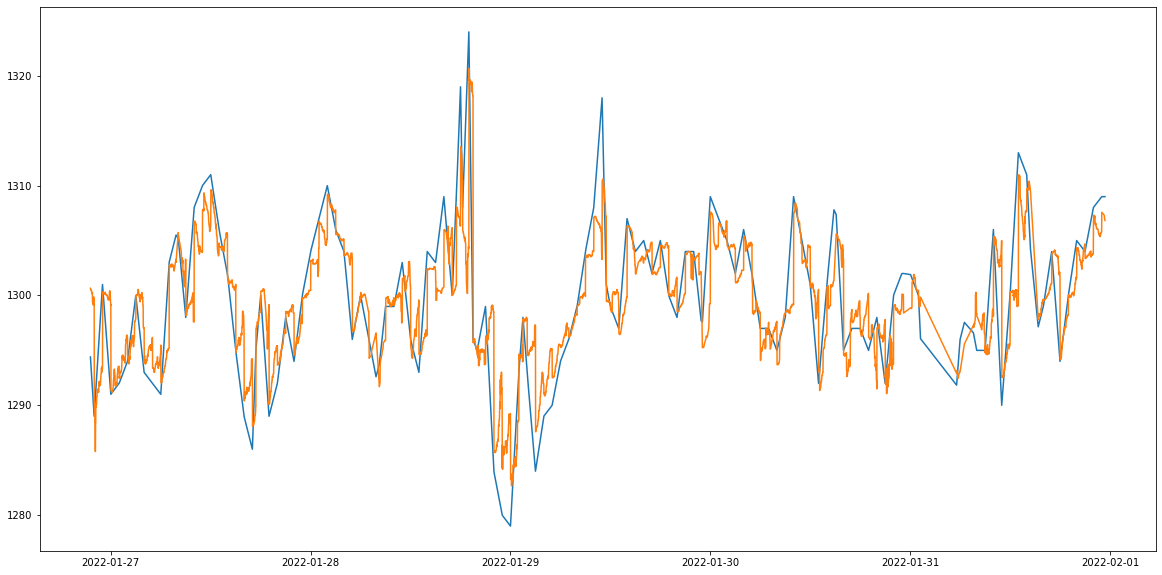

In [171]:
X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['temp_zuz']),
        df['temp_zuz'],
        test_size=0.01,
        shuffle=False
        )

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)

plt.figure(figsize=(20, 10))

plt.plot(X_test.index, y_test)
plt.plot(X_test.index, y_hat)

## Trenowanie modelu

In [170]:
pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('xgb', model)])

pipe.fit(df.drop(columns=['temp_zuz']), df['temp_zuz'])

Pipeline(steps=[('scalar', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

## Zapis wytrenowanego modelu

In [136]:
pickle.dump(pipe, open('model.sav', 'wb'))